In [ ]:
import glob
import os
import pandas as pd
import numpy as np
import shutil
import librosa
from tqdm import tqdm

In [ ]:
def extract_feature(file_name, **kwargs):
    mfcc = kwargs.get("mfcc")
    chroma = kwargs.get("chroma")
    mel = kwargs.get("mel")
    contrast = kwargs.get("contrast")
    tonnetz = kwargs.get("tonnetz")
    X, sample_rate = librosa.core.load(file_name)
    if chroma or contrast:
        stft = np.abs(librosa.stft(X))
    result = np.array([])
    if mfcc:
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
        result = np.hstack((result, mfccs))
    if chroma:
        chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
        result = np.hstack((result, chroma))
    if mel:
        mel = np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
        result = np.hstack((result, mel))
    if contrast:
        contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0)
        result = np.hstack((result, contrast))
    if tonnetz:
        tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X), sr=sample_rate).T,axis=0)
        result = np.hstack((result, tonnetz))
    return result

In [ ]:
dirname = "data"

if not os.path.isdir(dirname):
    os.mkdir(dirname)


csv_files = glob.glob("*.csv")

for j, csv_file in enumerate(csv_files):
    print("[+] Preprocessing", csv_file)
    df = pd.read_csv(csv_file)
    # only take filename and gender columns
    new_df = df[["filename", "gender"]]
    print("Previously:", len(new_df), "rows")
    # take only male & female genders (i.e droping NaNs & 'other' gender)
    new_df = new_df[np.logical_or(new_df['gender'] == 'female', new_df['gender'] == 'male')]
    print("Now:", len(new_df), "rows")
    new_csv_file = os.path.join(dirname, csv_file)
    # save new preprocessed CSV 
    new_df.to_csv(new_csv_file, index=False)
    # get the folder name
    folder_name, _ = csv_file.split(".")
    audio_files = glob.glob(f"{folder_name}/{folder_name}/*")
    all_audio_filenames = set(new_df["filename"])
    for i, audio_file in tqdm(list(enumerate(audio_files)), f"Extracting features of {folder_name}"):
        splited = os.path.split(audio_file)
        # audio_filename = os.path.join(os.path.split(splited[0])[-1], splited[-1])
        audio_filename = f"{os.path.split(splited[0])[-1]}/{splited[-1]}"
        # print("audio_filename:", audio_filename)
        if audio_filename in all_audio_filenames:
            # print("Copyying", audio_filename, "...")
            src_path = f"{folder_name}/{audio_filename}"
            target_path = f"{dirname}/{audio_filename}"
            #create that folder if it doesn't exist
            if not os.path.isdir(os.path.dirname(target_path)):
                os.mkdir(os.path.dirname(target_path))
            features = extract_feature(src_path, mel=True)
            target_filename = target_path.split(".")[0]
            np.save(target_filename, features)
            # shutil.copyfile(src_path, target_path)

In [1]:
import pandas as pd
import numpy as np
import os
import tqdm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv("balanced-all.csv")
df.head()

,filename,gender
0,data/cv-other-train/sample-069205.npy,female
1,data/cv-valid-train/sample-063134.npy,female
2,data/cv-other-train/sample-080873.npy,female
3,data/cv-other-train/sample-105595.npy,female
4,data/cv-valid-train/sample-144613.npy,female


In [3]:
df.tail()

,filename,gender
66933,data/cv-valid-train/sample-171098.npy,male
66934,data/cv-other-train/sample-022864.npy,male
66935,data/cv-valid-train/sample-080933.npy,male
66936,data/cv-other-train/sample-012026.npy,male
66937,data/cv-other-train/sample-013841.npy,male


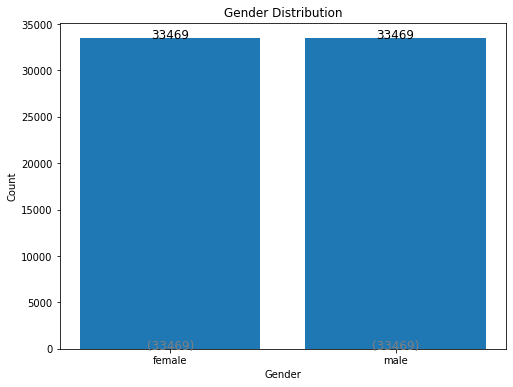

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the CSV file into a pandas DataFrame
# df = pd.read_csv('your_csv_file.csv')

# Group the data by gender and count the occurrences
gender_counts = df['gender'].value_counts()

# Plotting the bar plot with labels
plt.figure(figsize=(8, 6))
plt.bar(gender_counts.index, gender_counts.values)
plt.title('Gender Distribution')
plt.xlabel('Gender')
plt.ylabel('Count')

# Adding labels to the bars
for i, count in enumerate(gender_counts.values):
    plt.text(i, count + 10, str(count), ha='center', fontsize=12)
    plt.text(i, -70, f"({count})", ha='center', fontsize=12, color='gray')

plt.show()


In [5]:
# get total samples
n_samples = len(df)
# get total male samples
n_male_samples = len(df[df['gender'] == 'male'])
# get total female samples
n_female_samples = len(df[df['gender'] == 'female'])
print("Total samples:", n_samples)
print("Total male samples:", n_male_samples)
print("Total female samples:", n_female_samples)

Total samples: 66938
Total male samples: 33469
Total female samples: 33469


In [6]:
label2int = {
    "male": 1,
    "female": 0
}

def load_data(vector_length=128):
    """A function to load gender recognition dataset from `data` folder
    After the second run, this will load from results/features.npy and results/labels.npy files
    as it is much faster!"""
    # make sure results folder exists
    if not os.path.isdir("results"):
        os.mkdir("results")
    # if features & labels already loaded individually and bundled, load them from there instead
    if os.path.isfile("results/features.npy") and os.path.isfile("results/labels.npy"):
        X = np.load("results/features.npy")
        y = np.load("results/labels.npy")
        return X, y
    # read dataframe
    df = pd.read_csv("balanced-all.csv")
    # get total samples
    n_samples = len(df)
    # get total male samples
    n_male_samples = len(df[df['gender'] == 'male'])
    # get total female samples
    n_female_samples = len(df[df['gender'] == 'female'])
    print("Total samples:", n_samples)
    print("Total male samples:", n_male_samples)
    print("Total female samples:", n_female_samples)
    # initialize an empty array for all audio features
    X = np.zeros((n_samples, vector_length))
    # initialize an empty array for all audio labels (1 for male and 0 for female)
    y = np.zeros((n_samples, 1))
    for i, (filename, gender) in tqdm.tqdm(enumerate(zip(df['filename'], df['gender'])), "Loading data", total=n_samples):
        features = np.load(filename)
        X[i] = features
        y[i] = label2int[gender]
    # save the audio features and labels into files
    # so we won't load each one of them next run
    np.save("results/features", X)
    np.save("results/labels", y)
    return X, y

In [7]:
def split_data(X, y, test_size=0.1, valid_size=0.1):
    # split training set and testing set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=7)
    # split training set and validation set
    X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=valid_size, random_state=7)
    # return a dictionary of values
    return {
        "X_train": X_train,
        "X_valid": X_valid,
        "X_test": X_test,
        "y_train": y_train,
        "y_valid": y_valid,
        "y_test": y_test
    }

In [8]:
# load the dataset
X, y = load_data()
# split the data into training, validation and testing sets
data = split_data(X, y, test_size=0.1, valid_size=0.1)

In [9]:
len(X)

66938

In [10]:
def create_model(vector_length=128):
    
    model = Sequential()
    model.add(Dense(256, input_shape=(vector_length,)))
    model.add(Dropout(0.3))
    model.add(Dense(256, activation="relu"))
    model.add(Dropout(0.3))
    model.add(Dense(128, activation="relu"))
    model.add(Dropout(0.3))
    model.add(Dense(128, activation="relu"))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation="relu"))
    model.add(Dropout(0.3))
    # one output neuron with sigmoid activation function, 0 means female, 1 means male
    model.add(Dense(1, activation="sigmoid"))
    # using binary crossentropy as it's male/female classification (binary)
    model.compile(loss="binary_crossentropy", metrics=["accuracy"], optimizer="adam")
    # print summary of the model
    model.summary()
    return model

In [11]:
# construct the model
model = create_model()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               33024     
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 128)               1

In [12]:

print(len(data['X_train']))
print(len(data['y_train'])) 

54219
54219


In [13]:
# define early stopping to stop training after 5 epochs of not improving
early_stopping = EarlyStopping(mode="min", patience=10, restore_best_weights=True)

batch_size = 64
epochs = 100        
# train the model using the training set and validating using validation set
history = model.fit(data["X_train"], data["y_train"], epochs=epochs, batch_size=batch_size, validation_data=(data["X_valid"], data["y_valid"]),callbacks=[early_stopping])


Epoch 1/100
848/848 [==============================] - 22s 18ms/step - loss: 0.5591 - accuracy: 0.7660 - val_loss: 0.3969 - val_accuracy: 0.8423
Epoch 2/100
848/848 [==============================] - 16s 19ms/step - loss: 0.4165 - accuracy: 0.8335 - val_loss: 0.3412 - val_accuracy: 0.8669
Epoch 3/100
848/848 [==============================] - 23s 27ms/step - loss: 0.3809 - accuracy: 0.8507 - val_loss: 0.3257 - val_accuracy: 0.8662
Epoch 4/100
848/848 [==============================] - 16s 18ms/step - loss: 0.3673 - accuracy: 0.8589 - val_loss: 0.2995 - val_accuracy: 0.8783
Epoch 5/100
848/848 [==============================] - 14s 17ms/step - loss: 0.3440 - accuracy: 0.8668 - val_loss: 0.3134 - val_accuracy: 0.8754
Epoch 6/100
848/848 [==============================] - 13s 15ms/step - loss: 0.3371 - accuracy: 0.8715 - val_loss: 0.2809 - val_accuracy: 0.8911
Epoch 7/100
848/848 [==============================] - 13s 15ms/step - loss: 0.3278 - accuracy: 0.8750 - val_loss: 0.2754 - val_ac

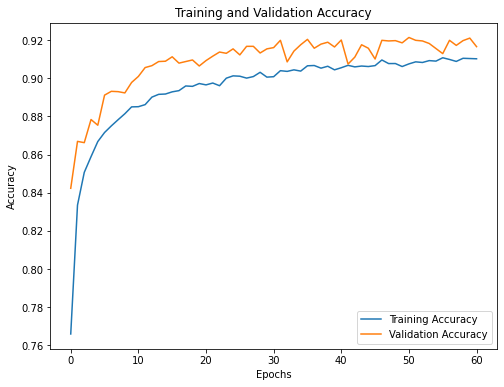

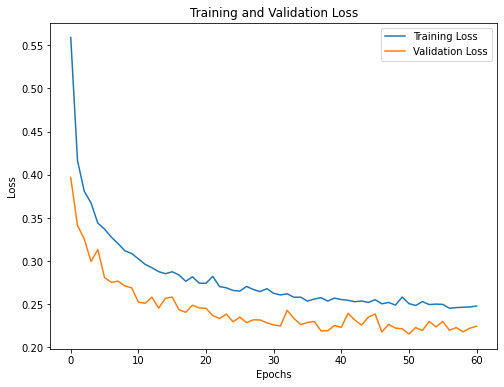

Training Loss: 0.2480
Training Accuracy: 91.02%
Validation Loss: 0.2245
Validation Accuracy: 91.65%


In [14]:
# Plotting training and validation accuracy
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plotting training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Printing training accuracy and loss
train_loss = history.history['loss'][-1]
train_accuracy = history.history['accuracy'][-1]
print(f"Training Loss: {train_loss:.4f}")
print(f"Training Accuracy: {train_accuracy*100:.2f}%")

# Printing validation accuracy and loss
val_loss = history.history['val_loss'][-1]
val_accuracy = history.history['val_accuracy'][-1]
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy*100:.2f}%")


Evaluating the model using 6694 samples...
Loss: 0.2163
Accuracy: 92.13%


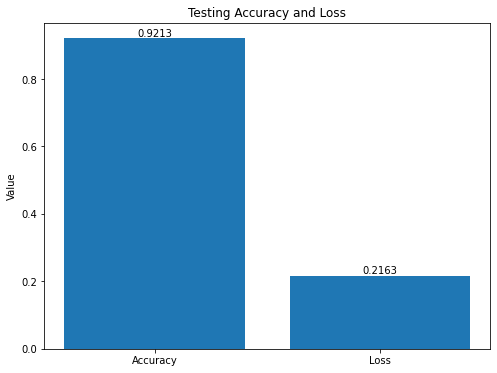

In [15]:
import matplotlib.pyplot as plt

# evaluating the model using the testing set
print(f"Evaluating the model using {len(data['X_test'])} samples...")
loss, accuracy = model.evaluate(data["X_test"], data["y_test"], verbose=0)
print(f"Loss: {loss:.4f}")
print(f"Accuracy: {accuracy*100:.2f}%")

# Bar plot for testing accuracy and loss
metrics = ['Accuracy', 'Loss']
values = [accuracy, loss]

plt.figure(figsize=(8, 6))
plt.bar(metrics, values)
plt.title('Testing Accuracy and Loss')
plt.ylabel('Value')

for i, v in enumerate(values):
    plt.text(i, v, f"{v:.4f}", ha='center', va='bottom')

plt.show()


In [16]:
import json

# Convert the model to JSON string
model_json = model.to_json()

# Save the JSON string to a file
with open("gender_model.json", "w") as json_file:
    json_file.write(model_json)

print("Model saved as JSON file.")


Model saved as JSON file.


In [17]:
model.save_weights("gender_model.h5")

In [18]:
from tensorflow.keras.models import model_from_json

# Load the model architecture from JSON file
with open("gender_model.json", "r") as json_file:
    loaded_model_json = json_file.read()
loaded_model = model_from_json(loaded_model_json)

# Load the model weights from HDF5 file
loaded_model.load_weights("gender_model.h5")
# Compile the loaded model
loaded_model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

print("Model loaded successfully.")


Model loaded successfully.


Evaluating the model using 6694 samples...
Loss: 0.2163
Accuracy: 92.13%


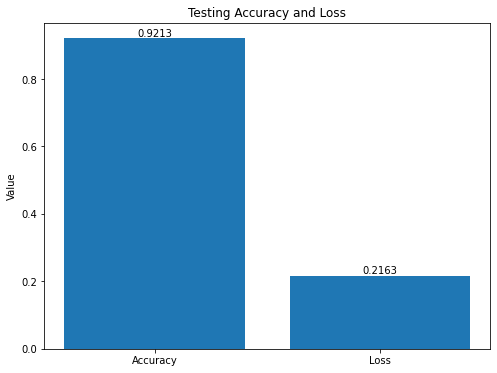

In [19]:
import matplotlib.pyplot as plt

# evaluating the model using the testing set
print(f"Evaluating the model using {len(data['X_test'])} samples...")
loss, accuracy = loaded_model.evaluate(data["X_test"], data["y_test"], verbose=0)
print(f"Loss: {loss:.4f}")
print(f"Accuracy: {accuracy*100:.2f}%")

# Bar plot for testing accuracy and loss
metrics = ['Accuracy', 'Loss']
values = [accuracy, loss]

plt.figure(figsize=(8, 6))
plt.bar(metrics, values)
plt.title('Testing Accuracy and Loss')
plt.ylabel('Value')

for i, v in enumerate(values):
    plt.text(i, v, f"{v:.4f}", ha='center', va='bottom')

plt.show()


# Testing with Sample Data

In [ ]:
import librosa
import numpy as np

def extract_feature(file_name, **kwargs):
    
    mfcc = kwargs.get("mfcc")
    chroma = kwargs.get("chroma")
    mel = kwargs.get("mel")
    contrast = kwargs.get("contrast")
    tonnetz = kwargs.get("tonnetz")
    X, sample_rate = librosa.core.load(file_name)
    if chroma or contrast:
        stft = np.abs(librosa.stft(X))
    result = np.array([])
    if mfcc:
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
        result = np.hstack((result, mfccs))
    if chroma:
        chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
        result = np.hstack((result, chroma))
    if mel:
        mel = np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
        result = np.hstack((result, mel))
    if contrast:
        contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0)
        result = np.hstack((result, contrast))
    if tonnetz:
        tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X), sr=sample_rate).T,axis=0)
        result = np.hstack((result, tonnetz))
    return result

In [ ]:
file = "recording.wav"
features = extract_feature(file, mel=True).reshape(1, -1)
# predict the gender!
male_prob = model.predict(features)[0][0]
female_prob = 1 - male_prob
gender = "male" if male_prob > female_prob else "female"
# show the result!
print("Result:", gender)
print(f"Probabilities::: Male: {male_prob*100:.2f}%    Female: {female_prob*100:.2f}%")